In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dataloader

In [2]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import time

import glob
import matplotlib.pyplot as plt
import cv2


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.manual_seed(0)

In [3]:
class myDataset(Dataset):
    
    def __init__(self, root, _transforms = None):
        
        self.transform = transforms.Compose(_transforms)
        
        self.domain_A_files = glob.glob(os.path.join(root, "photo_jpg", "*.jpg"))
        self.domain_B_files = glob.glob(os.path.join(root, "monet_jpg", "*.jpg"))
        
    def __len__(self):
        
        return(max(len(self.domain_A_files), len(self.domain_B_files)))
             
    def __getitem__(self, ind):
        
        item_A = self.transform(Image.open(self.domain_A_files[ind % len(self.domain_A_files)]))
        
        item_B = self.transform(Image.open(self.domain_B_files[random.randint(0, len(self.domain_B_files) - 1)]))
        
        return {"A":item_A, "B":item_B}

In [4]:
#Define Transforms

_transforms = [transforms.Resize((256,256)),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]

In [5]:
root = "gan-getting-started"
DATASET = myDataset(root, _transforms)

In [6]:
dataloader = DataLoader(DATASET, batch_size = 1, shuffle = True)

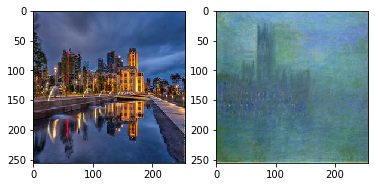

In [7]:
sample_set = next(iter(dataloader))
imageA = sample_set["A"][0]
imageA = imageA.permute(1,2,0)

imageB = sample_set["B"][0]
imageB = imageB.permute(1,2,0)

plt.subplot(1,2,1)
plt.imshow(imageA * 0.5 + 0.5)
plt.subplot(1,2,2)
plt.imshow(imageB * 0.5 + 0.5)

# Build Generator/ Discriminator

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

In [10]:
class Generator(nn.Module):
    
    def __init__(self, in_size, out_size, n_res_blocks):
        
        super (Generator, self).__init__()
        
        layers = []
        
        # 64*7*7 conv layer, stride 1, pad 3
        layer1 = [nn.ReflectionPad2d(3), 
                  nn.Conv2d(in_size, 64, 7, 1),
                  nn.InstanceNorm2d(64),
                  nn.ReLU(inplace = True)]
        
        layers.extend(layer1)
        
        # 128*3*3, stride 2, pad 1
        
        layer2 = [nn.Conv2d(64, 128, 3, 2, 1),
                 nn.InstanceNorm2d(128),
                 nn.ReLU(inplace = True)
                 ]
        
        layers.extend(layer2)
        
        # 256*3*3, stride 2, pad 1
        layer3 = [nn.Conv2d(128, 256, 3, 2,1),
                 nn.InstanceNorm2d(256),
                 nn.ReLU(inplace = True)]
        
        layers.extend(layer3)
        
        # Res blocks
        for i in range(n_res_blocks):            
            layers.extend(ResidualBlock(256).conv_block)
        
            
        #128*3*3 convtranspose stride 2, pad 1, out_pad 1
        
        layer5 = [nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
                  nn.InstanceNorm2d(128),
                  nn.ReLU(inplace = True)]
        
        layers.extend(layer5)
        
        
        #64*3*3 convtranspose stride2, pad1, out_pad1
        layer6 = [nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
          nn.InstanceNorm2d(64),
          nn.ReLU(inplace = True)]
        
        layers.extend(layer6)
        
        #3*7*7 conv, stride 1, pad 3
        
        layer7 = [nn.Conv2d(64, out_size, 7, 1, 3),
                 nn.Tanh()]
        
        layers.extend(layer7)
        
        
        self.model = nn.Sequential(*layers)
        
    def forward(self,x):
        
        return self.model(x)

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, in_size):
        super(Discriminator,self).__init__()
        
        layers = []
        
        # 64*4*4 conv, stride 2, pad 1
        layer1 = [nn.Conv2d(in_size, 64, 4, 2, 1),
                 nn.InstanceNorm2d(64),
                 nn.LeakyReLU(0.2, inplace = True)]
        layers.extend(layer1)
        # 128*4*4 conv, stride 2, pad 1
        layer2 = [nn.Conv2d(64,128,4,2,1),
                 nn.InstanceNorm2d(128),
                 nn.LeakyReLU(0.2,inplace = True)]
        layers.extend(layer2)
        # 256*4*4 conv, stride 2, pad 1
        layer3 = [nn.Conv2d(128,256,4,2,1),
                 nn.InstanceNorm2d(256),
                 nn.LeakyReLU(0.2,inplace = True)]
        layers.extend(layer3)
        # 521*4*4 conv, stride 1, pad 1
        layer4 = [nn.Conv2d(256, 521, 4, 1, 1),
                 nn.InstanceNorm2d(521),
                 nn.LeakyReLU(0.2, inplace = True)]
        layers.extend(layer4)
        # 1*4*4 conv, stride 1, pad 1
        layer5 = [nn.Conv2d(521, 1,4,1,1)]
        layers.extend(layer5)
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## 2.1 One-step test

In [12]:
batch = next(iter(dataloader))
real_photo = batch["A"].cuda()
real_monet = batch["B"].cuda()
Gan = Generator(3,3,9).cuda()
Dis_model = Discriminator(3).cuda()
gan_photo = Gan(real_photo)
dis_photo = Dis_model(real_photo)
print(gan_photo.shape)
print(dis_photo.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 30, 30])


In [18]:
def image_print(image):
    
    image = image[0]
    image = image.permute(1,2,0).cpu().detach().numpy()
    image = image * 0.5 + 0.5
    plt.imshow(image)

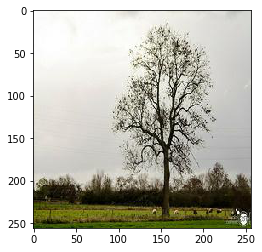

In [19]:
image_print(real_photo)

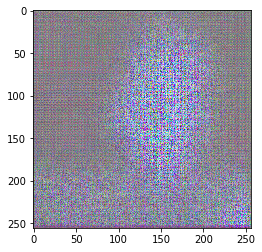

In [22]:
image_print(gan_photo)

# 3 Training

In [50]:
_batch_size = 1
_n_epoch = 30
_lr = 1e-3
_in_size = 3
_out_size = 3
_n_res = 9
_gan_mode = "lsgan"
_Lambda = 10

In [51]:
# Initialize Network
#from photo to image
Gan_A2B = Generator(_in_size, _out_size, _n_res)

#from image to photo
Gan_B2A = Generator(_out_size, _in_size, _n_res)

Dis_A = Discriminator(_in_size)
Dis_B = Discriminator(_out_size)

In [52]:
## Check if cuda is available
if torch.cuda.is_available():
    Gan_A2B.cuda()
    Gan_B2A.cuda()
    Dis_A.cuda()
    Dis_B.cuda()
    print("cuda is ready")
else:
    print("cuda device is unavailable")

cuda is ready


In [53]:
#Define Loss
if _gan_mode == "lsgan":
    criterion_GAN = nn.MSELoss()
elif _gan_mode == "vanilla":
    criterion_GAN = nn.BCEWithLogitsLoss()
    
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [54]:
# Define Optimizers
optimizer_GA2B = torch.optim.Adam(Gan_A2B.parameters(), lr = _lr, betas = (0.5, 0.999))
optimizer_GB2A = torch.optim.Adam(Gan_B2A.parameters(), lr = _lr, betas = (0.5,0.999))
optimizer_DA = torch.optim.Adam(Dis_A.parameters(), lr=_lr, betas=(0.5, 0.999))
optimizer_DB = torch.optim.Adam(Dis_B.parameters(), lr=_lr, betas=(0.5, 0.999))

In [55]:
def save_model(path):
    Gan_A2B.eval()
    Gan_B2A.eval()
    Dis_A.eval()
    Dis_B.eval()
    
    torch.save({
    'ganA2B': Gan_A2B.state_dict(),
    'ganB2A': Gan_B2A.state_dict(),
    'disA': Dis_A.state_dict(),
    'disB': Dis_B.state_dict(),
        
    'optimizerA2B': optimizer_GA2B.state_dict(),
    'optimizerB2A': optimizer_GB2A.state_dict(),
    'optimizerDA': optimizer_DA.state_dict(),
    'optimizerDB': optimizer_DB.state_dict(),
        
    }, path)

In [56]:
def load_model(path):
    
    checkpoint = torch.load(path)
    
    Gan_A2B.load_state_dict(checkpoint['ganA2B'])
    Gan_B2A.load_state_dict(checkpoint['ganB2A'])
    Dis_A.load_state_dict(checkpoint['disA'])
    Dis_B.load_state_dict(checkpoint['disB'])
    
    optimizer_GA2B.load_state_dict(checkpoint['optimizerA2B'])
    optimizer_GB2A.load_state_dict(checkpoint['optimizerB2A'])
    optimizer_DA.load_state_dict(checkpoint['optimizerDA'])
    optimizer_DB.load_state_dict(checkpoint['optimizerDB'])


In [57]:

class ReplayBuffer():
    
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))
    


In [58]:

fake_A_Buffer = ReplayBuffer()
fake_B_Buffer = ReplayBuffer()


In [27]:
def train():
    
    global G_loss, D_A_loss, D_B_loss
    
    for epoch in range(_n_epoch):
        
        t = time.time()


        print(
            f'Epoch: {epoch+19} ' + \
            f'Gan_loss: {G_loss} D_A_loss: {D_A_loss} D_B_loss: {D_B_loss}'+\
            f'time: {(time.time() - t):.5f}'
        )
        #############!!!CHANGE WHEN RE-TRAINING######################3
        
        path = f'last-checkpoint-{epoch + 19}.bin'
        
        save_model(Gan_A2B, Gan_B2A, Dis_A, Dis_B, optimizer_GA2B, optimizer_GB2A, optimizer_DA, optimizer_DB, epoch, path)
        
        for i, batch in enumerate(dataloader):
            
            real_photo = batch["A"].cuda()
            real_monet = batch["B"].cuda()
            
            #######################Update Generators#################
            
            optimizer_GA2B.zero_grad()
            optimizer_GB2A.zero_grad()
            
            #identity loss
            identity_photo = Gan_B2A(real_photo)
            identity_monet = Gan_A2B(real_monet)
            
            identity_loss = criterion_identity(real_photo, identity_photo) + criterion_identity(real_monet, identity_monet)
            identity_loss *= (0.5*_Lambda)
            
            #GAN loss
            fake_photo = Gan_B2A(real_monet)
            fake_monet = Gan_A2B(real_photo)
            
            fake_photo_D = Dis_A(fake_photo)
            fake_monet_D = Dis_B(fake_monet)
            
            gan_loss = criterion_GAN(fake_photo_D, torch.ones_like(fake_photo_D))
            gan_loss += criterion_GAN(fake_monet_D, torch.ones_like(fake_monet_D))
            
            #Cycle Loss
            
            recovered_photo = Gan_B2A(fake_monet)
            recovered_monet = Gan_A2B(fake_photo)
            
            cycle_loss = criterion_cycle(recovered_photo, real_photo)
            cycle_loss += criterion_cycle(recovered_monet, real_monet)
            
            cycle_loss *= _Lambda
            
            #Total Loss
            
            total_loss = identity_loss + gan_loss + cycle_loss
            total_loss.backward()
            
            G_loss = total_loss.item()
            
            optimizer_GA2B.step()
            optimizer_GB2A.step()
            
            #######################Update Discriminators#################
            
            optimizer_DA.zero_grad()
            
            pred_real = Dis_A(real_photo)
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
            
            fake_photo = fake_A_Buffer.push_and_pop(fake_photo)
            pred_fake = Dis_A(fake_photo.detach())
            loss_D_fake = criterion_GAN(fake_photo, torch.zeros_like(fake_photo))
            
            #Calculate loss_DA
            loss_DA = (loss_D_real + loss_D_fake)/2
            
            D_A_loss = loss_DA
            
            loss_DA.backward()
            optimizer_DA.step()
            
            optimizer_DB.zero_grad()
            pred_real = Dis_B(real_monet)
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
            
            fake_monet = fake_B_Buffer.push_and_pop(fake_monet)
            pred_fake = Dis_B(fake_monet.detach())
            loss_D_fake = criterion_GAN(fake_monet, torch.zeros_like(fake_monet))
            
            #Calculate Loss_DB
            loss_DB = (loss_D_real + loss_D_fake)/2
            
            D_B_loss = loss_DB
            
            loss_DB.backward()
            optimizer_DB.step()
            
            
            

In [112]:
G_loss = "None"
D_A_loss = "None"
D_B_loss = "None"
base_dir = './'

#train()
path = f'save0915/last-checkpoint-27.bin'
epoch = 0
checkpoint = torch.load(path)

In [113]:
load_model(path)

In [114]:
batch = next(iter(dataloader))
real_photo = batch["A"].cuda()
gen_photo = Gan_A2B(real_photo)

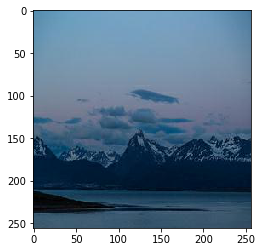

In [115]:
image_print(real_photo)

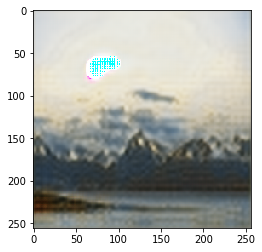

In [116]:
image_print(gen_photo)

In [117]:
train()

NameError: name 'train' is not defined

In [110]:

#Epoch: 0 Gan_loss: None D_A_loss: None D_B_loss: Nonetime: 0.00000
#Epoch: 1 Gan_loss: 8.64466667175293 D_A_loss: 0.16776761412620544 D_B_loss: 0.09472344070672989time: 0.00466
#Epoch: 2 Gan_loss: 9.864384651184082 D_A_loss: 0.15965023636817932 D_B_loss: 0.19935284554958344time: 0.00464
#Epoch: 3 Gan_loss: 6.804034233093262 D_A_loss: 0.09801415354013443 D_B_loss: 0.10159613937139511time: 0.00480
#Epoch: 4 Gan_loss: 11.04388427734375 D_A_loss: 0.11954721808433533 D_B_loss: 0.08149801194667816time: 0.00453
#Epoch: 5 Gan_loss: 7.029119968414307 D_A_loss: 0.1428418755531311 D_B_loss: 0.11766662448644638time: 0.00321
#Epoch: 6 Gan_loss: 6.725749969482422 D_A_loss: 0.07873336970806122 D_B_loss: 0.0993320494890213time: 0.00410
#Epoch: 7 Gan_loss: 5.494945526123047 D_A_loss: 0.1949121206998825 D_B_loss: 0.12285377085208893time: 0.00392
#Epoch: 8 Gan_loss: 5.575497627258301 D_A_loss: 0.05396510288119316 D_B_loss: 0.11190684139728546time: 0.00378
#Epoch: 9 Gan_loss: 10.691508293151855 D_A_loss: 0.07016188651323318 D_B_loss: 0.11584508419036865time: 0.00413
#Epoch: 10 Gan_loss: 5.093144416809082 D_A_loss: 0.1717260479927063 D_B_loss: 0.10090019553899765time: 0.00364
#Epoch: 11 Gan_loss: 5.833339214324951 D_A_loss: 0.12936054170131683 D_B_loss: 0.11497944593429565time: 0.00230
#Epoch: 12 Gan_loss: 5.576460838317871 D_A_loss: 0.11735547333955765 D_B_loss: 0.1277690976858139time: 0.00366
#Epoch: 13 Gan_loss: 5.344193935394287 D_A_loss: 0.1104627475142479 D_B_loss: 0.0832233801484108time: 0.00200
#Epoch: 14 Gan_loss: 4.077540874481201 D_A_loss: 0.17297208309173584 D_B_loss: 0.10088512301445007time: 0.00449
#Epoch: 15 Gan_loss: 4.97957706451416 D_A_loss: 0.1381770223379135 D_B_loss: 0.0961504653096199time: 0.00460
#Epoch: 16 Gan_loss: 5.515985012054443 D_A_loss: 0.10713501274585724 D_B_loss: 0.06408585608005524time: 0.00401
#Epoch: 17 Gan_loss: 4.614585876464844 D_A_loss: 0.07399849593639374 D_B_loss: 0.08403370529413223time: 0.00364
#Epoch: 18 Gan_loss: 4.950119972229004 D_A_loss: 0.10461610555648804 D_B_loss: 0.05252794548869133time: 0.00383
#Epoch: 19 Gan_loss: 4.144896984100342 D_A_loss: 0.12262679636478424 D_B_loss: 0.1047598198056221time: 0.00415
#Epoch: 20 Gan_loss: 4.23469877243042 D_A_loss: 0.11308558285236359 D_B_loss: 0.06606413424015045time: 0.00365
#Epoch: 21 Gan_loss: 6.637097358703613 D_A_loss: 0.11268219351768494 D_B_loss: 0.12082992494106293time: 0.00488
#Epoch: 22 Gan_loss: 4.364043235778809 D_A_loss: 0.17249011993408203 D_B_loss: 0.09061560779809952time: 0.00435
#Epoch: 23 Gan_loss: 4.662528991699219 D_A_loss: 0.16654667258262634 D_B_loss: 0.12207431346178055time: 0.00508
#Epoch: 24 Gan_loss: 5.412324905395508 D_A_loss: 0.07571706920862198 D_B_loss: 0.07048188894987106time: 0.00534
#Epoch: 25 Gan_loss: 5.5003509521484375 D_A_loss: 0.07052101194858551 D_B_loss: 0.07577060908079147time: 0.00462
#Epoch: 26 Gan_loss: 4.328004360198975 D_A_loss: 0.20657071471214294 D_B_loss: 0.09017013013362885time: 0.00294
#Epoch: 27 Gan_loss: 5.948275089263916 D_A_loss: 0.0991949513554573 D_B_loss: 0.08787667006254196time: 0.00402
